# Intro to stats Learning

## Lab 6b - Ridge and Lasso regression

In [1]:
using Pkg ; Pkg.activate("D:/JULIA/6_ML_with_Julia/ISL-lab-6b") ; Pkg.instantiate()

  Activating project at `D:\JULIA\6_ML_with_Julia\ISL-lab-6b`


> Getting started
> 1. Data preparation
> Ridge pipeline
> 1. Baseline
> 2. Basic Ridge
> 3. Cross validating <br>

> Lasso pipeline <br>
> Elastic net pipeline <br>

regression to the Hitters R dataset.

### Getting started

---

In [2]:
using MLJ
import RDatasets: dataset
using PrettyPrinting
import Distributions
const D = Distributions

LinearRegressor = @load LinearRegressor pkg = MLJLinearModels
RidgeRegressor = @load RidgeRegressor pkg = MLJLinearModels
LassoRegressor = @load LassoRegressor pkg = MLJLinearModels

import MLJLinearModels

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


 ✔
import MLJLinearModels ✔
import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


MLJLinearModels.LassoRegressor

We load the dataset using the dataset function, which takes the Package and dataset names as arguments.

In [3]:
hitters = dataset("ISLR", "Hitters")
@show size(hitters)
names(hitters) |> pprint

size(hitters) = (322, 20)
["AtBat",
 "Hits",
 "HmRun",
 "Runs",
 "RBI",
 "Walks",
 "Years",
 "CAtBat",
 "CHits",
 "CHmRun",
 "CRuns",
 "CRBI",
 "CWalks",
 "League",
 "Division",
 "PutOuts",
 "Assists",
 "Errors",
 "Salary",
 "NewLeague"]

Let's unpack the dataset with the ```unpack``` function. In this case, the target is ```Salary (==(:Salary))``` and all other columns are features ```(col->true)```.

In [4]:
y, X = unpack(hitters, ==(:Salary), col -> true);

The target has missing values which we will just ignore. We extract the row indices corresponding to non-missing values of the target. Note the use of the element-wise operator ```.```.

In [5]:
no_miss = .!ismissing.(y);

We collect the non missing values of the target in an Array.

In [6]:
# And keep only the corresponding features values.

y = collect(skipmissing(y))
X = X[no_miss, :]

# Let's now split our dataset into a train and test sets.
train, test = partition(eachindex(y), 0.5, shuffle = true, rng = 424);

Let's have a look at the target.

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\jeffr\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


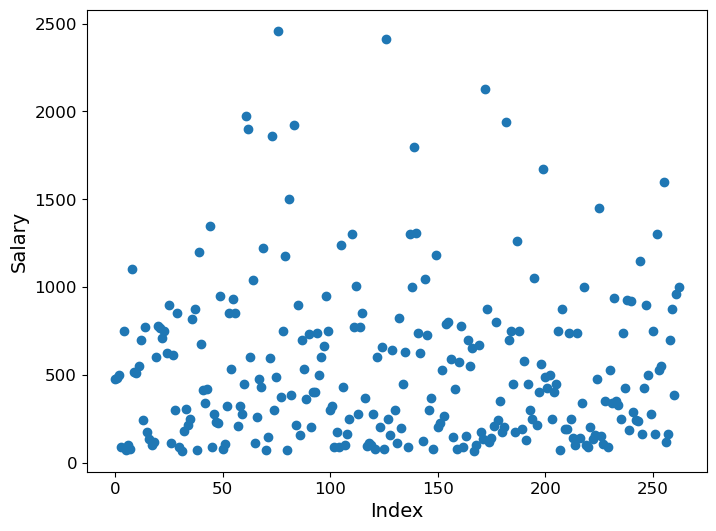

In [7]:
using PyPlot

figure(figsize = (8, 6))
plot(y, ls = "none", marker = "o")

xticks(fontsize = 12)
yticks(fontsize = 12)
xlabel("Index", fontsize = 14)
ylabel("Salary", fontsize = 14)

savefig("./plots/3.5.1.png")

That looks quite skewed, let's have a look at a histogram:

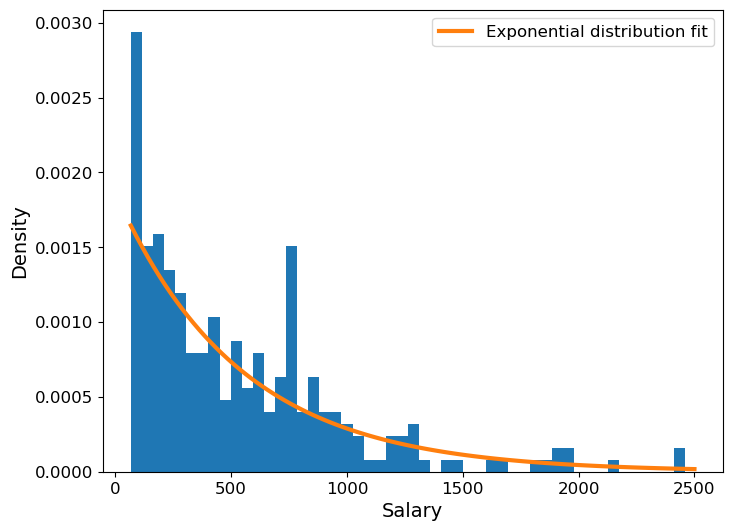

In [8]:
figure(figsize = (8,6))
hist(y, bins = 50, density = true)

xticks(fontsize = 12)
yticks(fontsize = 12)
xlabel("Salary", fontsize = 14)
ylabel("Density", fontsize = 14)

edfit = D.fit_mle(D.Exponential, y)
xx = range(minimum(y), 2500, length = 100)
yy = pdf.(edfit, xx)
plot(xx, yy, lw = 3, label = "Exponential distribution fit")

legend(fontsize = 12)
savefig("./plots/3.5.2.png")

### Data preparation

Most features are currently encoded as integers but we will consider them as continuous. To coerce int features to Float, we nest the autotype function in the coerce function. The autotype function returns a dictionary containing scientific types, which is then passed to the coerce function. For more details on the use of autotype, see the Scientific Types

In [9]:
schema(X)

┌───────────┬───────────────┬─────────────────────────────────┐
│ names     │ scitypes      │ types                           │
├───────────┼───────────────┼─────────────────────────────────┤
│ AtBat     │ Count         │ Int32                           │
│ Hits      │ Count         │ Int32                           │
│ HmRun     │ Count         │ Int32                           │
│ Runs      │ Count         │ Int32                           │
│ RBI       │ Count         │ Int32                           │
│ Walks     │ Count         │ Int32                           │
│ Years     │ Count         │ Int32                           │
│ CAtBat    │ Count         │ Int32                           │
│ CHits     │ Count         │ Int32                           │
│ CHmRun    │ Count         │ Int32                           │
│ CRuns     │ Count         │ Int32                           │
│ CRBI      │ Count         │ Int32                           │
│ CWalks    │ Count         │ Int32     

In [10]:
Xc = coerce(X, autotype(X, rules = (:discrete_to_continuous,)))
scitype(Xc)

Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{2}}}}

In [11]:
schema(Xc)

┌───────────┬───────────────┬─────────────────────────────────┐
│ names     │ scitypes      │ types                           │
├───────────┼───────────────┼─────────────────────────────────┤
│ AtBat     │ Continuous    │ Float64                         │
│ Hits      │ Continuous    │ Float64                         │
│ HmRun     │ Continuous    │ Float64                         │
│ Runs      │ Continuous    │ Float64                         │
│ RBI       │ Continuous    │ Float64                         │
│ Walks     │ Continuous    │ Float64                         │
│ Years     │ Continuous    │ Float64                         │
│ CAtBat    │ Continuous    │ Float64                         │
│ CHits     │ Continuous    │ Float64                         │
│ CHmRun    │ Continuous    │ Float64                         │
│ CRuns     │ Continuous    │ Float64                         │
│ CRBI      │ Continuous    │ Float64                         │
│ CWalks    │ Continuous    │ Float64   

In [12]:
# count를 continuous로 바꾸는 함수

autotype(X, rules = (:discrete_to_continuous,))

Dict{Symbol, Type} with 16 entries:
  :CAtBat  => Continuous
  :CRBI    => Continuous
  :AtBat   => Continuous
  :Errors  => Continuous
  :Assists => Continuous
  :Years   => Continuous
  :HmRun   => Continuous
  :Walks   => Continuous
  :CRuns   => Continuous
  :CWalks  => Continuous
  :Runs    => Continuous
  :Hits    => Continuous
  :CHits   => Continuous
  :CHmRun  => Continuous
  :PutOuts => Continuous
  :RBI     => Continuous

In [13]:
coerce(X, autotype(X, rules = (:discrete_to_continuous,)))

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0
6,185.0,37.0,1.0,23.0,8.0,21.0,2.0,214.0,42.0
7,298.0,73.0,0.0,24.0,24.0,7.0,3.0,509.0,108.0
8,323.0,81.0,6.0,26.0,32.0,8.0,2.0,341.0,86.0
9,401.0,92.0,17.0,49.0,66.0,65.0,13.0,5206.0,1332.0


There're a few features that are categorical which we'll one-hot-encode.

### Ridge pipeline

---

### Baseline

Let's first fit a simple pipeline with a standardizer, a one-hot-encoder and a basic linear regression:

In [14]:
model = Pipeline(Standardizer(), OneHotEncoder(), LinearRegressor())

DeterministicPipeline(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    one_hot_encoder = OneHotEncoder(
            features = Symbol[],
            drop_last = false,
            ordered_factor = true,
            ignore = false),
    linear_regressor = LinearRegressor(
            fit_intercept = true,
            solver = nothing),
    cache = true)

In [15]:
pipe = machine(model, Xc, y)
fit!(pipe, rows = train)
ŷ = MLJ.predict(pipe, rows = test)
round(rms(ŷ, y[test])^2, sigdigits = 4)

┌ Info: Training Machine{DeterministicPipeline{NamedTuple{,…},…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Training Machine{OneHotEncoder,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Spawning 2 sub-features to one-hot encode feature :League.
└ @ MLJModels C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\builtins\Transformers.jl:1142
┌ Info: Spawning 2 sub-features to one-hot encode feature :Division.
└ @ MLJModels C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\builtins\Transformers.jl:1142
┌ Info: Spawning 2 sub-features to one-hot encode feature :NewLeague.
└ @ MLJModels C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\builtins\Transformers.jl:1142
┌ Info: Training Machine{LinearRegressor,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


123500.0

Let's get a feel for how we're doing

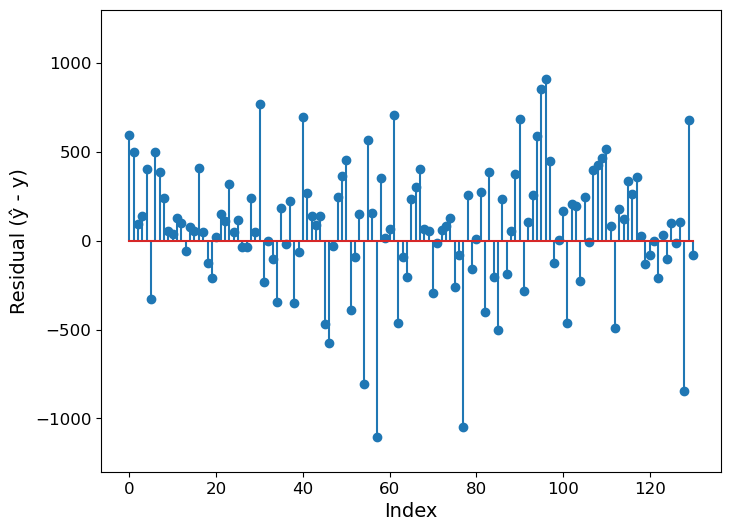

In [16]:
figure(figsize = (8, 6))

res = ŷ .- y[test]
stem(res)

xticks(fontsize = 12)
yticks(fontsize = 12)
xlabel("Index", fontsize = 14)
ylabel("Residual (ŷ - y)", fontsize = 14)

ylim([-1300, 1300])
savefig("./plots/3.5.3.png")

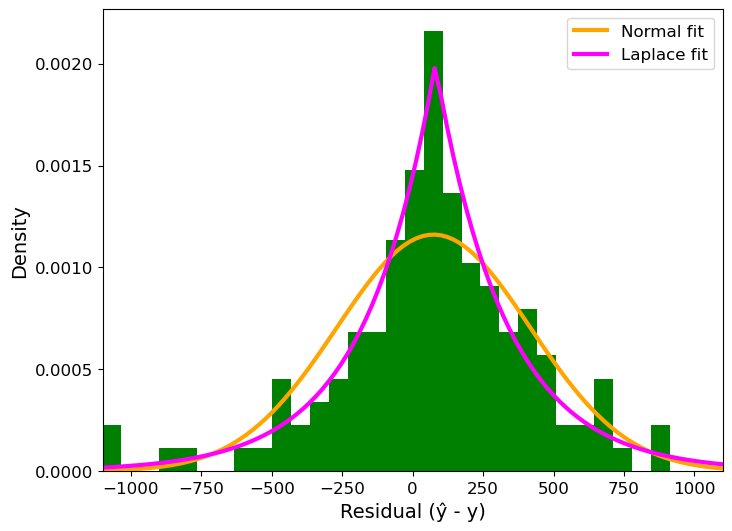

In [17]:
figure(figsize = (8, 6))
hist(res, bins = 30, density = true, color = "green")

xx = range(-1100, 1100, length = 100)
ndfit = D.fit_mle(D.Normal, res)
lfit = D.fit_mle(D.Laplace, res)

plot(xx, pdf.(ndfit, xx), lw = 3, color = "orange", label = "Normal fit")
plot(xx, pdf.(lfit, xx), lw = 3, color = "magenta", label = "Laplace fit")

legend(fontsize = 12)

xticks(fontsize = 12)
yticks(fontsize = 12)
xlabel("Residual (ŷ - y)", fontsize = 14)
ylabel("Density", fontsize = 14)
xlim([-1100, 1100])

savefig("./plots/3.5.4.png")

###  Basic Ridge

Let's now swap the linear regressor for a Ridge one without specifying the penalty (```1``` by default): We modify the supervised model in the pipeline directly.

In [18]:
pipe.model.linear_regressor = RidgeRegressor()
fit!(pipe, rows = train)
ŷ = MLJ.predict(pipe, rows = test)
round(rms(ŷ, y[test])^2, sigdigits = 4)

┌ Info: Updating Machine{DeterministicPipeline{NamedTuple{,…},…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:465
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Training Machine{OneHotEncoder,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Spawning 2 sub-features to one-hot encode feature :League.
└ @ MLJModels C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\builtins\Transformers.jl:1142
┌ Info: Spawning 2 sub-features to one-hot encode feature :Division.
└ @ MLJModels C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\builtins\Transformers.jl:1142
┌ Info: Spawning 2 sub-features to one-hot encode feature :NewLeague.
└ @ MLJModels C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\builtins\Transformers.jl:1142
┌ Info: Training Machine{RidgeRegressor,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


119800.0

Ok that's a bit better but surely we can do better with an appropriate selection of the hyperparameter.

### Cross validation

What penalty should you use? Let's do a simple CV to try to find out:

In [19]:
r = range(model, :(linear_regressor.lambda), lower = 1e-2, upper = 100_000, scale = :log10)
tm = TunedModel(model = model, 
                ranges = r, 
                tuning = Grid(resolution = 50),
                resampling = CV(nfolds = 3, rng =4141),
                measure = rms)
mtm = machine(tm, Xc, y)
fit!(mtm, rows = train)

best_mdl = fitted_params(mtm).best_model
round(best_mdl.linear_regressor.lambda, sigdigits = 4)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Attempting to evaluate 50 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 50 metamodels: 100%[=========================] Time: 0:00:03


0.3728

right, and with that we get:

In [20]:
ŷ = MLJ.predict(mtm, rows = test)
round(rms(ŷ, y[test])^2, sigdigits = 4)

98040.0

Let's see:

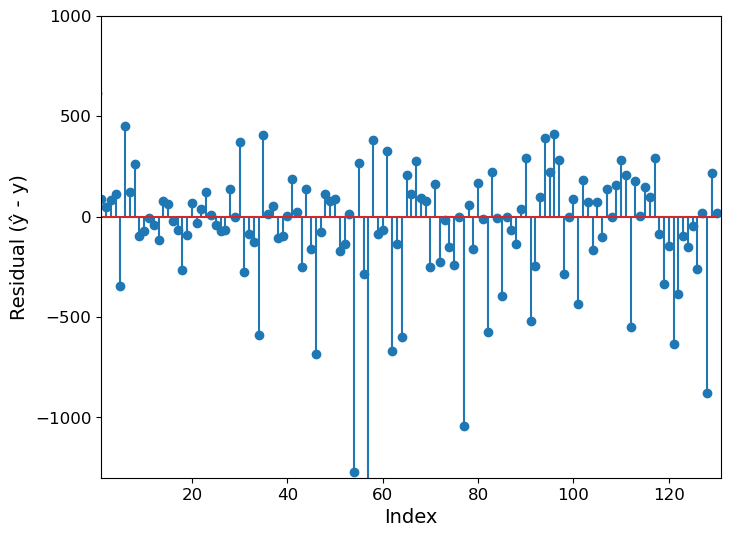

In [21]:
figure(figsize = (8,6))

res = ŷ .- y[test]
stem(res)

xticks(fontsize = 12); yticks(fontsize = 12)
xlabel("Index", fontsize = 14);
ylabel("Residual (ŷ - y)", fontsize = 14)
xlim(1, length(res))

ylim([-1300, 1000])
savefig("./plots/3.5.5.png")

You can compare that with the residuals obtained earlier.

### Lasso pipeline

---

Let's do the same as above but using a Lasso model and adjusting the range a bit:

* **mtm**: Machine trained 1 time

* **mtm.model**: Deterministic Tuned Model

* **mtm.model.model**: Deterministic Pipeline

* **mtm.model.model.linear_regressor**: RidgeRegressor(lambda = 1.0, fit_intercept = true, penalize_intercept = false, scale_penalty_with_samples = true, solver = nothing)

In [22]:
mtm

Machine{DeterministicTunedModel{Grid,…},…} trained 1 time; caches data
  model: MLJTuning.DeterministicTunedModel{Grid, MLJBase.DeterministicPipeline{NamedTuple{(:standardizer, :one_hot_encoder, :linear_regressor), Tuple{Unsupervised, Unsupervised, Deterministic}}, MLJModelInterface.predict}}
  args: 
    1:	Source @053 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{2}}}}`
    2:	Source @989 ⏎ `AbstractVector{Continuous}`


In [23]:
mtm.model

DeterministicTunedModel(
    model = DeterministicPipeline(
            standardizer = Standardizer,
            one_hot_encoder = OneHotEncoder,
            linear_regressor = RidgeRegressor,
            cache = true),
    tuning = Grid(
            goal = nothing,
            resolution = 50,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 3,
            shuffle = true,
            rng = Random.MersenneTwister(4141)),
    measure = RootMeanSquaredError(),
    weights = nothing,
    operation = nothing,
    range = NumericRange(0.01 ≤ linear_regressor.lambda ≤ 100000; origin=50000.005, unit=49999.995) on log10 scale,
    selection_heuristic = MLJTuning.NaiveSelection(nothing),
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPU1{Nothing}(nothing),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true,
    cache = true)

In [24]:
mtm.model.model

DeterministicPipeline(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    one_hot_encoder = OneHotEncoder(
            features = Symbol[],
            drop_last = false,
            ordered_factor = true,
            ignore = false),
    linear_regressor = RidgeRegressor(
            lambda = 1.0,
            fit_intercept = true,
            penalize_intercept = false,
            scale_penalty_with_samples = true,
            solver = nothing),
    cache = true)

In [25]:
mtm.model.model.linear_regressor

RidgeRegressor(
    lambda = 1.0,
    fit_intercept = true,
    penalize_intercept = false,
    scale_penalty_with_samples = true,
    solver = nothing)

In [26]:
mtm.model.model.linear_regressor = LassoRegressor()
mtm.model.range = range(model, 
                        :(linear_regressor.lambda),
                        lower = 500,
                        upper = 100_000,
                        scale = :log10)

fit!(mtm, rows = train)

┌ Info: Updating Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:465
┌ Info: Attempting to evaluate 50 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 50 metamodels: 100%[=========================] Time: 0:00:03


Machine{DeterministicTunedModel{Grid,…},…} trained 2 times; caches data
  model: MLJTuning.DeterministicTunedModel{Grid, MLJBase.DeterministicPipeline{NamedTuple{(:standardizer, :one_hot_encoder, :linear_regressor), Tuple{Unsupervised, Unsupervised, Deterministic}}, MLJModelInterface.predict}}
  args: 
    1:	Source @053 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{2}}}}`
    2:	Source @989 ⏎ `AbstractVector{Continuous}`


In [27]:
best_mdl = fitted_params(mtm).best_model # 람다값이 2531.435... 모델 도출 

DeterministicPipeline(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    one_hot_encoder = OneHotEncoder(
            features = Symbol[],
            drop_last = false,
            ordered_factor = true,
            ignore = false),
    linear_regressor = LassoRegressor(
            lambda = 2531.4359405220866,
            fit_intercept = true,
            penalize_intercept = false,
            scale_penalty_with_samples = true,
            solver = nothing),
    cache = true)

In [28]:
round(best_mdl.linear_regressor.lambda, sigdigits = 4)

2531.0

Ok and let's see how that does:

In [29]:
ŷ = MLJ.predict(mtm, rows = test)
round(rms(ŷ, y[test])^2 , sigdigits = 4)

98330.0

In [30]:
fitted_params(mtm.fitresult)

(linear_regressor = (coefs = [:AtBat => -0.0, :Hits => 0.0, :HmRun => -0.0, :Runs => 82.33487884749947, :RBI => 0.0, :Walks => 37.883942482221414, :Years => -0.0, :CAtBat => 0.0, :CHits => 152.33401765158285, :CHmRun => 0.0  …  :CWalks => -0.0, :League__A => -0.0, :League__N => 0.0, :Division__E => 22.92070298764432, :Division__W => -45.330065388849924, :PutOuts => 64.09339067499211, :Assists => 0.0, :Errors => -0.0, :NewLeague__A => -0.0, :NewLeague__N => 0.0],
                     intercept = 555.6709756637332,),
 one_hot_encoder = (fitresult = OneHotEncoderResult,),
 standardizer = Dict(:CAtBat => (2457.318181818182, 2245.683113459936), :CRBI => (302.54545454545456, 304.26320374760013), :AtBat => (419.6515151515151, 152.79367842167332), :Errors => (8.68939393939394, 7.071210932886076), :Assists => (109.5, 139.8698686375009), :Years => (6.840909090909091, 4.659111643290977), :HmRun => (12.151515151515152, 8.852898648504043), :Walks => (41.07575757575758, 22.16579484822863), :CRuns =>

In [31]:
fitted_params(mtm.fitresult).linear_regressor

(coefs = [:AtBat => -0.0, :Hits => 0.0, :HmRun => -0.0, :Runs => 82.33487884749947, :RBI => 0.0, :Walks => 37.883942482221414, :Years => -0.0, :CAtBat => 0.0, :CHits => 152.33401765158285, :CHmRun => 0.0  …  :CWalks => -0.0, :League__A => -0.0, :League__N => 0.0, :Division__E => 22.92070298764432, :Division__W => -45.330065388849924, :PutOuts => 64.09339067499211, :Assists => 0.0, :Errors => -0.0, :NewLeague__A => -0.0, :NewLeague__N => 0.0],
 intercept = 555.6709756637332,)

Pretty good! and the parameters are reasonably sparse as expected:

In [32]:
coefs, intercept = fitted_params(mtm.fitresult).linear_regressor
@show coefs
@show intercept

coefs = [:AtBat => -0.0, :Hits => 0.0, :HmRun => -0.0, :Runs => 82.33487884749947, :RBI => 0.0, :Walks => 37.883942482221414, :Years => -0.0, :CAtBat => 0.0, :CHits => 152.33401765158285, :CHmRun => 0.0, :CRuns => 0.0, :CRBI => 28.535678620242805, :CWalks => -0.0, :League__A => -0.0, :League__N => 0.0, :Division__E => 22.92070298764432, :Division__W => -45.330065388849924, :PutOuts => 64.09339067499211, :Assists => 0.0, :Errors => -0.0, :NewLeague__A => -0.0, :NewLeague__N => 0.0]
intercept = 555.6709756637332


555.6709756637332

In [33]:
for (name, val) in coefs
    println("$(rpad(name, 8)):  $(round(val, sigdigits=3))")
end
println("Intercept: $(round(intercept, sigdigits=3))")

AtBat   :  -0.0
Hits    :  0.0
HmRun   :  -0.0
Runs    :  82.3
RBI     :  0.0
Walks   :  37.9
Years   :  -0.0
CAtBat  :  0.0
CHits   :  152.0
CHmRun  :  0.0
CRuns   :  0.0
CRBI    :  28.5
CWalks  :  -0.0
League__A:  -0.0
League__N:  0.0
Division__E:  22.9
Division__W:  -45.3
PutOuts :  64.1
Assists :  0.0
Errors  :  -0.0
NewLeague__A:  -0.0
NewLeague__N:  0.0
Intercept: 556.0


with around 50% sparsity:

In [34]:
coef_vals = [c[2] for c in coefs]
sum(coef_vals .≈ 0) / length(coefs)

0.6818181818181818

Let's visualise this:

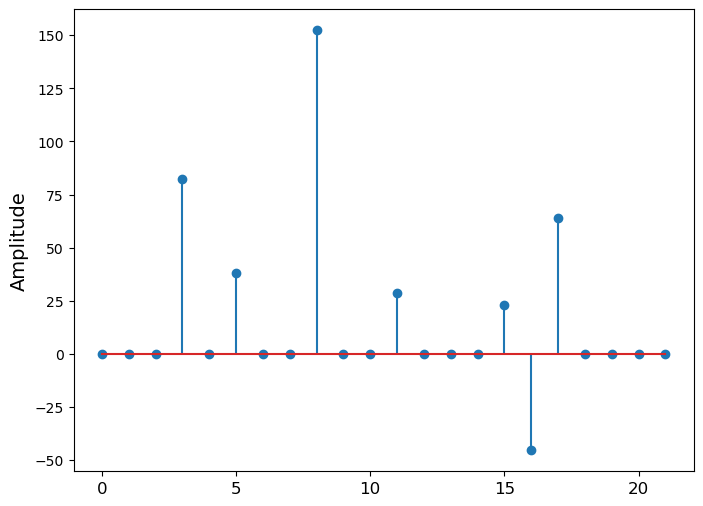

In [35]:
figure(figsize = (8, 6))
stem(coef_vals)

# name of the feature including one-hot-encoded ones
all_names = [:AtBat, :Hits, :HmRun, :Runs, :RBI, :Walks, :Years,
             :CAtBat, :CHits, :CHmRun, :CRuns, :CRBI, :CWalks,
             :League__A, :League__N, :Div_E, :Div_W,
             :PutOuts, :Assists, :Errors, :NewLeague_A, :NewLeague_N]

idxshow = collect(1:length(coef_vals))[abs.(coef_vals) .> 10]
xticks(fontsize = 12)
ylabel("Amplitude", fontsize = 14)
savefig("./plots/3.5.6.png")

### Elastic net pipeline

---

In [36]:
ElasticNetRegressor = @load ElasticNetRegressor pkg=MLJLinearModels

mtm.model.model.linear_regressor = ElasticNetRegressor()
mtm.model.range = [range(model, :(linear_regressor.lambda), lower = 0.1, upper = 100, scale=:log10),
                    range(model, :(linear_regressor.gamma), lower = 500, upper = 10_000, scale=:log10)]
mtm.model.tuning = Grid(resolution = 10)
fit!(mtm, rows = train)

best_mdl = fitted_params(mtm).best_model
@show round(best_mdl.linear_regressor.lambda, sigdigits = 4)
@show round(best_mdl.linear_regressor.gamma, sigdigits = 4)

import MLJLinearModels

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


 ✔


┌ Info: Updating Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:465
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels

Evaluating over 100 metamodels:   7%[=>                       ]  ETA: 0:00:28┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\

Evaluating over 100 metamodels:  14%[===>                     ]  ETA: 0:00:14┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\

Evaluating over 100 metamodels:  21%[=====>                   ]  ETA: 0:00:09┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\

Evaluating over 100 metamodels:  28%[=======>                 ]  ETA: 0:00:06┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\

Evaluating over 100 metamodels:  35%[========>                ]  ETA: 0:00:04┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\

Evaluating over 100 metamodels:  42%[==========>              ]  ETA: 0:00:03┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\

Evaluating over 100 metamodels:  49%[============>            ]  ETA: 0:00:03┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\

Evaluating over 100 metamodels:  56%[==============>          ]  ETA: 0:00:02┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\

Evaluating over 100 metamodels:  63%[===============>         ]  ETA: 0:00:02┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\

Evaluating over 100 metamodels:  70%[=================>       ]  ETA: 0:00:01┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\

Evaluating over 100 metamodels:  77%[===================>     ]  ETA: 0:00:01┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\

Evaluating over 100 metamodels:  84%[=====================>   ]  ETA: 0:00:01┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\

Evaluating over 100 metamodels:  91%[======================>  ]  ETA: 0:00:00┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\

Evaluating over 100 metamodels:  98%[========================>]  ETA: 0:00:00┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:50
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\jeffr\.julia\packages\MLJLinearModels\oDTrS\src\fit\proxgrad.jl:64
┌ Warning: No appropriate stepsize found via backtracking; interrupting. The reason could be input data that is not standardized.
└ @ MLJLinearModels C:\Users\

round(best_mdl.linear_regressor.lambda, sigdigits = 4) = 0.1
round(best_mdl.linear_regressor.gamma, sigdigits = 4) = 7169.0


7169.0

And it's not too bad in terms of accuracy either

In [37]:
ŷ = MLJ.predict(mtm, rows = test)
round(rms(ŷ, y[test])^2, sigdigits = 4)

128500.0